# House Price Prediction 


## Introduction

The following presentation aims to outline a possible solution to the famous "Housing Price Prediction" challenge, where we are to predict the saleprice of a house based on information about the given house. In the presentation we provide plots were it is feasable, but we try to convey our message through mostly with short consiste statements and theory. A "scratchbook" consisting of the used code are supplied to support our claims, and give the reader an oppertunity to examine the code himself. Our key findings about the properties of the dataset are outline in the *Data Exploration* section, before the data is processed and prepared in the *Data Preparation* section. The statistical models are implemented and tested towards the end, before the presentation are concluded with a discussion on the model performance.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

The trainingset and testset are loaded from files. The training set containes 1200 rows, and the testset containes 260 rows, making for a total of 1406 rows in our dataset.

In [0]:
trainset = pd.read_csv('train.csv', index_col=0)
testset = pd.read_csv('test.csv', index_col=0)

To give the reader an overview of the raw data, the head of the dataset are presented below. It can be observed that the dataset consists of 80 features which provide information about various aspects of the house. Some features are numerical and some are categorical. The target feature are named 'SalePrice' and tells us how much the house was sold for, in USD.

In [0]:
print(trainset.head())

    MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                    ...                                  
1           60       RL         65.0  ...        WD        Normal    208500
2           20       RL         80.0  ...        WD        Normal    181500
3           60       RL         68.0  ...        WD        Normal    223500
4           70       RL         60.0  ...        WD       Abnorml    140000
5           60       RL         84.0  ...        WD        Normal    250000

[5 rows x 80 columns]


## Data Exploration

An important step in every machine learning project is to understand what the dataset containes, and how it is characterized. This is done to create a broad picture of important trends and major points to study in greater detail.

The dataset are first examined for missing values. A feature where many rows are missing entries, are useless and should be removed from both the trainingset and testset. The code below finds the features where more than 500 rows has missing entries, and plots the number of missing elements as a histogram. The same features are also droped from the dataset. It can be seen that there are four feature where almost all the rows has missing entries, and one feature where about 700 rows has missing entries.

One could argue that the rows that are missing entries for certain features, can have values extrapolated from similar rows. This is true when there are few missing values across the dataset, but cannot be done accurately when most of the rows miss the same featurevalue. 

A value of 500 are chosen based on trial and error, and can of course be adjusted to better suit other cases.

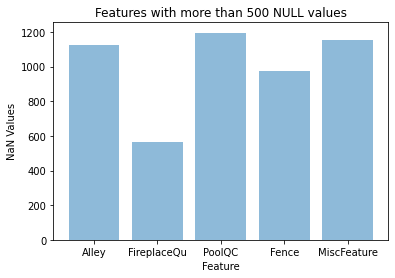

In [0]:
threshold = 500
sparse_features = []
null_values = []
for feature in trainset:
    if((trainset.isna().sum()[feature])>threshold and feature!='SalePrice'):
        sparse_features.append(feature)
        null_values.append(trainset.isna().sum()[feature])
y_pos = np.arange(len(sparse_features)) 
plt.bar(y_pos, null_values, align='center', alpha=0.5)
plt.xticks(y_pos, sparse_features)
plt.ylabel('NaN Values')
plt.xlabel('Feature')
plt.title('Features with more than ' + str(threshold) + ' NULL values')
plt.show()

trainset = trainset.drop(sparse_features, axis=1)
testset = testset.drop(sparse_features, axis=1)

It can be seen that features like **PoolQC** which contains information about the quality of the pool, and **MiscFeature** which contains information about miscellaneous feature not covered in other categories, has almost no entries which are non-null. 

The next step is to examine the outliers. Outliers are datapoints that are too different from the rest, to use to train our model. Outliers are assumed to be so different that its impossible for our model to predict them, and they should falt out be removed. This is **only** done for the trainingset, as we can not change what data that are passed to the model for prediction. It can be observed from the figure below that we have outliers in the following features, if we define an outlier as a datapoint that are more than 3 standard deviations away from the mean.


*   LotArea
*   MasVnrArea
*   TotalBsmtSF
*   1stFlrSF
*   2ndFlrSF
*   GrLivArea



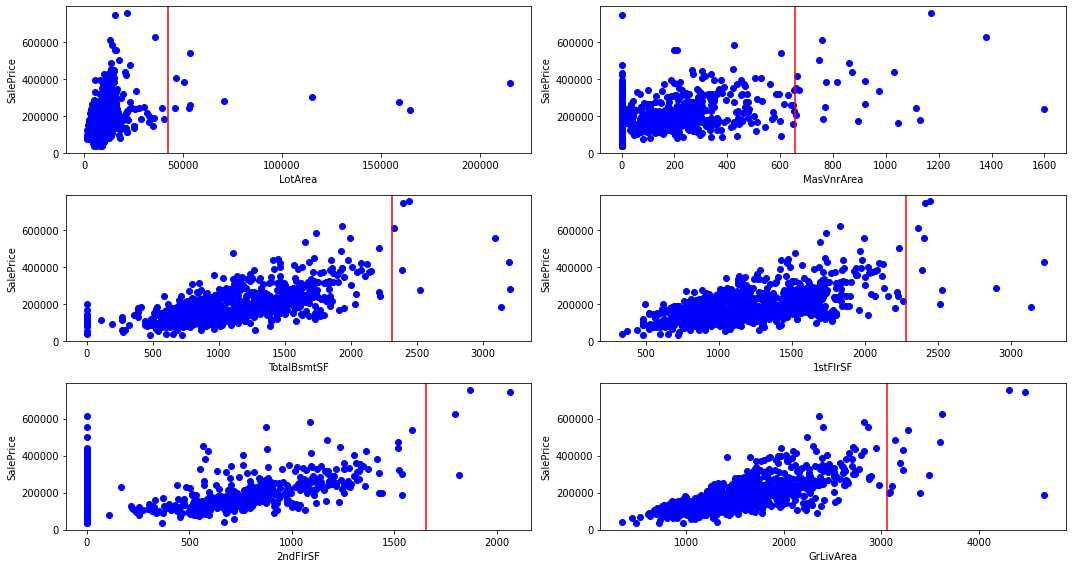

In [0]:
def plot_outliers(features):
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))
  i=1
  for f in features:
    plt.subplot(3, 2, i)
    plt.plot(trainset[f], trainset['SalePrice'], 'bo')
    plt.axvline(x=(np.mean(trainset[f])+3*np.std(trainset[f])), color='r')
    plt.ylabel('SalePrice')
    plt.xlabel(f)
    i+=1
  fig.tight_layout()

plot_outliers(['LotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'])

As stated earlier, the features in this dataset are of two types. We have catergorical features where the value are one of n categories, and we have numerical features that have nummerical values. To examine how many features we have in each category, lists of the categorical and numerical features are generated below befor their lengths are stated.

It can be seen that we have roughly the same amount of features in both categories.

In [0]:
numerical_features = trainset.select_dtypes([np.number]).columns
print("Number of numerical features: ", len(numerical_features))
categorical_features = trainset.select_dtypes([np.object]).columns
print("Number of categorical features: ", len(categorical_features))

all_features = [numerical_features, categorical_features]

Number of numerical features:  37
Number of categorical features:  38


By examining how the different features are corrolated with the target feature, we can get a quantitative measure on how "important" a feature are in regards to prediciting the sale price. If a feature are highly corrolated with the 'SalePrice' feature, we know that we can tell a lot about the sale price by studying this feature, and vice versa. The corrolation between the *numerical* features and the 'SalePrice' feature are found from the codeblock below.

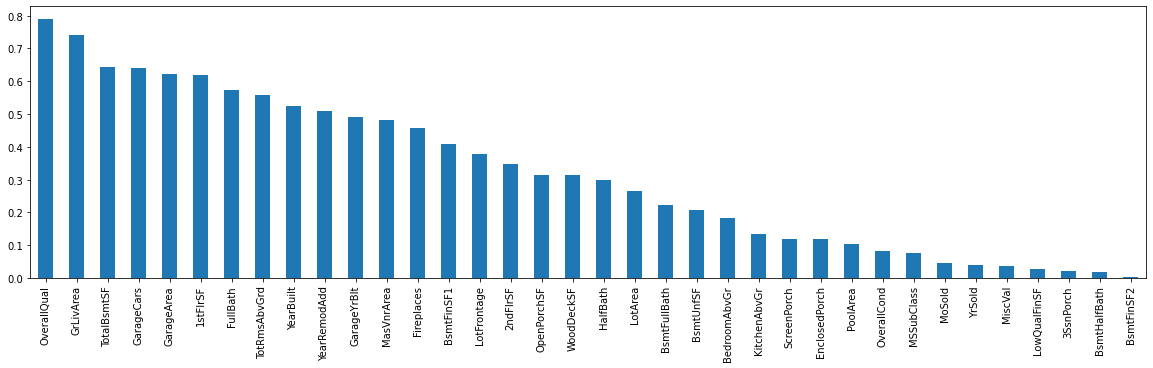

In [0]:
numerical_corr = trainset.corr().SalePrice.abs().drop('SalePrice')
numerical_corr_sorted = numerical_corr.sort_values(ascending=False) 
numerical_corr_sorted.plot(kind='bar',figsize=(20,5))
plt.show()

It can be observed that the **OverallQual** feature, that rates the overall quality of the house, are most corrolated with the sale price. The features **GrLivAre** and **GarageCars** that contains information about the gross living area and the number of cars in the garage, follow closely behind. These features are, because of their high corrolation with the target, very importatnt for predicting the target. In the other end of the spectrum, we find features like **BsmtFinSF2** and **BsmtHalfBath** which containes information about various characteristics of the basement.



To find the corrolation between the sales price and the categorical features, we can not use the same approcah as above. We are still interested in finding how a change in a categorical feature affects a change in the sales price, but we no longer have numerical values which can describe the value of the features. By encoding the categrorical features we are able to find mutual information between the features and the sales price, which can be used in much the same way as the corrolation. The codeblock below calulates a quantitative measurement of the amount of mutual information between the categrorical features and the sales price. If it is a lot of mutual information the number are high, and if it is little mutual information the number are low.

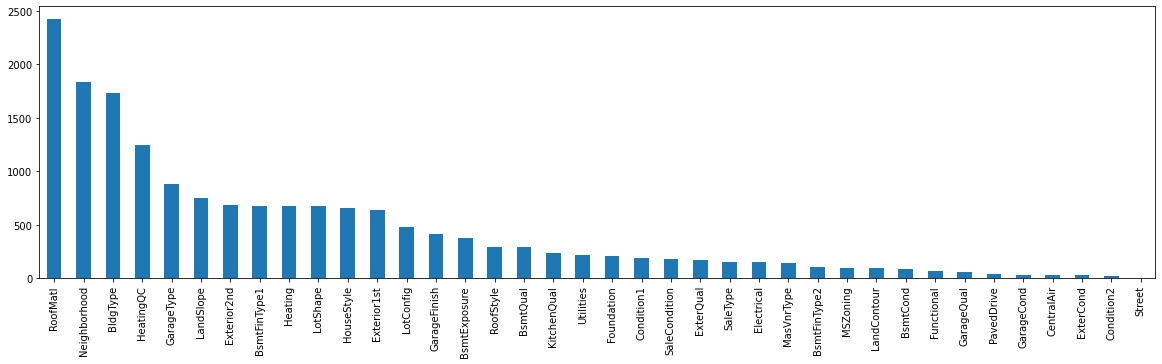

In [0]:
categorical_dataset = trainset.drop(numerical_features, axis=1, inplace=False)
categorical_dataset['SalePrice'] = trainset['SalePrice']
categorical_dataset = categorical_dataset.dropna(axis=0)
ordinalEncoder = OrdinalEncoder()
ordinalEncoder.fit(categorical_dataset.drop('SalePrice', axis=1))
features = SelectKBest(score_func=chi2, k='all')
features.fit(ordinalEncoder.transform(categorical_dataset.drop('SalePrice', axis=1)), categorical_dataset.SalePrice)
mutual_numerical_features= pd.Series(features.scores_, index=categorical_features).sort_values(ascending=False)
mutual_numerical_features.plot(kind='bar',figsize=(20,5))
plt.show()

It can be observed that the categorical feature with the most mutual information are the **Neighborhood**, and the categorical features with the lowest mutual information are **Street** and **Condition2** which contains information about type of road access to the property and the proximity to various conditions, respectivly.

Even though we removed the very sparse features we still have features with null values, as seen from the result of the codeblock below.

In [0]:
features_contains_null = np.where(trainset.isnull().sum().values != 0)[0]
print('Feature which contains "null" values:')
print('')
for c in features_contains_null:
    column = trainset.columns[c]
    print(column)

Feature which contains "null" values:

LotFrontage
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond


These null values needs to be handeled in the data preparation step, but can be extrapolated from similar rows with a reasonable accuracy because we have a lot of non-null values on which this extrapolation can be based on.

Lastly, we do not wish to keep features that provide much the same information. If we have many features that are highly corrolated we might confuse our model so that it tries to find contexts in the data that should not be learned. In addition, we wish to reduce the number of features in the dataset so that our model can have a lower complexity and we reduce our risk of overfitting. Lastly, few features helps us get a good intuition of what information we feed our model. The codeblock below finds numerical features that are highly corrolated amongst themselves.

In [0]:

threshold = 0.9
mutualy_corrolate_columns = []
print('Features with high corrolation with eachother: ')
for f1 in numerical_features:
  for f2 in numerical_features:
    if(trainset[f1].corr(trainset[f2]) > 0.85): #The corrolation are too high
      if(f1 != f2):
        if((f1 != 'SalePrice') and (f2 != 'SalePrice')):
          mutualy_corrolate_columns.append(f1)
          print(f1)

Features with high corrolation with eachother: 
GarageCars
GarageArea


It can be seen that **GarageCars** and **GarageArea** has a high corrolation amongst themself, and we can remove one of them. Previoulsy it was shown that **GarageCars** has a higher corrolation with the target than **GarageArea**, so we remove **GarageArea**.

## Feature selection

Based on the information gathered in the previous secetion, we can drop the features we regard as useless or that contains no information we can use for our prediction.

The 10 numerical features that are the least corrrolated with the sales price are droped, as they provide little useful information. The number of dropped features ar to a certain extent arbitrary, but have proved to give reasonable results in the end. The choice is also based on the fact that the 10 least corrolated features have a corrolation below 0.10, and this can as such be regarded as a threshold.

In [0]:
n_drop_numerical = 10
numerical_low_corr_features = numerical_corr_sorted.index[-n_drop_numerical:]
print(numerical_low_corr_features)
trainset = trainset.drop(numerical_low_corr_features, axis=1)
testset = testset.drop(numerical_low_corr_features, axis=1)

Index(['PoolArea', 'OverallCond', 'MSSubClass', 'MoSold', 'YrSold', 'MiscVal',
       'LowQualFinSF', '3SsnPorch', 'BsmtHalfBath', 'BsmtFinSF2'],
      dtype='object')


Similarly, the 10 categorical features that have the lowest mutual information with the sales price, are droped in the codeblock below. The number of droped features are still a bit arbitrary, but proves to provide an accuracy that is satisfactorily.

In [0]:
n_drop_categorical = 10
categorical_low_corr_features = mutual_numerical_features.index[-n_drop_categorical:]
print(categorical_low_corr_features)
trainset = trainset.drop(categorical_low_corr_features, axis=1)
testset = testset.drop(categorical_low_corr_features, axis=1)

Index(['LandContour', 'BsmtCond', 'Functional', 'GarageQual', 'PavedDrive',
       'GarageCond', 'CentralAir', 'ExterCond', 'Condition2', 'Street'],
      dtype='object')


Because of **GarageArea**s high corrolation with **GarageCars**, we drop **GarageArea**.

In [0]:
trainset = trainset.drop('GarageArea', axis=1)
testset = testset.drop('GarageArea', axis=1)

## Data Preparation 

After having gained insight over our data, and selected the features we feel confident in proving our model useful information, we can try to imporve our models performance further by modifiying the selected features.

As seen from the data exploration step, there are many missing values in our dataset which we need to handle. For the nummerical case, the easiest way is to replace the missing entries with the mean value of that feature, giving us a quite accurate estimate of the missing value, on average. This is done for both the trainingset and testset.

In [0]:
numerical_features = trainset.select_dtypes([np.number]).columns
trainset[numerical_features] = trainset[numerical_features].fillna(trainset.mean())
print('Any nan numerical values left in the trainingset?: ', trainset[numerical_features].isnull().values.any())

numerical_features = testset.select_dtypes([np.number]).columns
testset[numerical_features] = testset[numerical_features].fillna(testset.mean())
print('Any nan numerical values left in the testingset?: ', testset[numerical_features].isnull().values.any())

Any nan numerical values left in the trainingset?:  False
Any nan numerical values left in the testingset?:  False


For the categorical case, on the other hand, we are not able to calulate an average. As a substitute, we replace the missing entries with a 'None'-value, and assume that these entries are not applicable for the particular dataentry. This is also done for both the trainingset and testingset.

In [0]:
categorical_features = trainset.select_dtypes([np.object]).columns
categorical_features_contains_nan = trainset.columns[trainset.isna().any()].tolist() 
for cat_feat in categorical_features_contains_nan:
    trainset[cat_feat] = trainset[cat_feat].fillna('None')

categorical_features = testset.select_dtypes([np.object]).columns
categorical_features_contains_nan = testset.columns[testset.isna().any()].tolist() 
for cat_feat in categorical_features_contains_nan:
    testset[cat_feat] = testset[cat_feat].fillna('None')


As seen from the data exploration step, the following outliers need to be removed.

In [0]:
trainset = trainset[(np.abs(stats.zscore(trainset['LotArea'])) < 3)]
trainset = trainset[(np.abs(stats.zscore(trainset['MasVnrArea'])) < 3)]
trainset = trainset[(np.abs(stats.zscore(trainset['TotalBsmtSF'])) < 3)]
trainset = trainset[(np.abs(stats.zscore(trainset['1stFlrSF'])) < 3)]
trainset = trainset[(np.abs(stats.zscore(trainset['2ndFlrSF'])) < 3)]
trainset = trainset[(np.abs(stats.zscore(trainset['GrLivArea'])) < 3)]

Next, the categorical features have to be encoded for the model to be able to process it. This is easily done by converting each categorical feature to a new binary encoded feature, using the pre-made function get_dummies. 

In [0]:
trainset = pd.get_dummies(trainset)
testset = pd.get_dummies(testset)

Because the testset might have different categorical values than the trainingset, we risk having a different number of features in the trainingset than in the testingset after the feature encoding. This issue is adressed by adding the missing binary features to the trainingset, and setting their value to zero. 

In [0]:
missing_cols = set(trainset.columns)-set(testset.columns)

for c in missing_cols:
    testset[c] = 0
    
testset = testset[trainset.columns]

## Statistical Analysis 

Many of the statistical procedures including regression assume some certain characteristics about the data. Since we did data explatory, the following is to check how 'SalePrice' complies with statistical assumptions.

- Linear Assumption. Linear regression assumes that the data have a linear relationship

- Gaussian Distributions. Linear regression will make more reliable predictions if our input and output variables are normally distributed



According to the assumptions of Linear Regression, data should be normally distributed and represent a linear relationship. **SalePrice** is the target variable for the prediction and by checking the distribution of it, we can decide if a log transformation is needed.

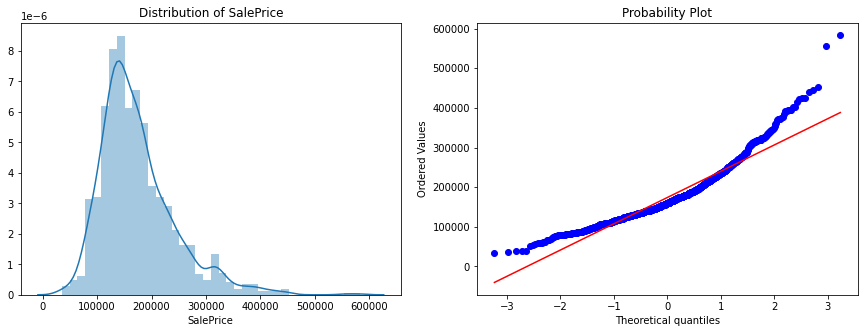

In [0]:
fig = plt.figure(figsize=(15,5))

#distribution graph
plt.subplot(1,2,1)
sns.distplot(trainset['SalePrice']);
plt.title('Distribution of SalePrice')

#Probability plot
plt.subplot(1,2,2)
stats.probplot(trainset['SalePrice'], plot=plt)
plt.show()

From the histograms above, the distribution of our target variable 'SalePrice' is skewed to the right and doesn't follow the normal line. Thus, for normalizing it, a log transformation should be applied.

**Convert skew of numerical features.**

Skewnewss quantifies how normal the distribution is.
- If skewness is less than -1 or greater than 1, the distribution is highly skewed.
- If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
- If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

In [0]:
# Display the skewness of each numerical feature and sort the values in descending order 
skewness = trainset[numerical_features].apply(lambda x: x.skew()).sort_values(ascending=False)

# Create a dataframe and show 5 most skewed features 
skewness_df = pd.DataFrame({'Skewness': skewness})
skewness_df.head()

,Skewness
KitchenAbvGr,4.592850
ScreenPorch,3.956858
EnclosedPorch,2.866082
OpenPorchSF,2.304222
LotFrontage,1.882983


According to the general rule, skewness with an absolute value less than 0.5 is considered as an acceptable range of skewness for normal distribution of data.

In [0]:
#Select skewness values above the limit  
skewness = skewness[abs(skewness) > 0.5].index

# Transform skewed features to normal distribution by taking log(1 + input)
skew_features = np.log1p(trainset[skewness])

## Train, validation and test split 

In [0]:
valsize = 150

train_set = trainset[:len(trainset.index)-valsize]
val_set = train_set[len(train_set.index)-valsize:]

[len(train_set.index), len(val_set.index), len(testset.index)]

[993, 150, 260]

## Model Selection

In [0]:
#For Training
trainset_y = train_set['SalePrice']
trainset_X = train_set.drop('SalePrice', axis=1)

valset_y = val_set['SalePrice']
valset_X = val_set.drop('SalePrice', axis=1)

#For Testing
train_set_X = trainset.drop('SalePrice', axis=1)
train_set_y = trainset['SalePrice']

testset_y = np.log(testset['SalePrice'])
testset_X = testset.drop('SalePrice', axis=1)

In order to assess the performance of the models we will use the Root Mean Square Error (RMSE) on the logarithms of the true values and the predicted values. The reason the logarithm is applied on the dependent variable values is because if a house costs 500,000€ and we predicted that it cost 485,000€ we were much more correct than if a house cost 10,000€ and we predict that it costs 1000€. Therefore we have a platform of comparing accuracies for the different levels (expensive or cheap) of house price.

In [0]:
def get_log_rmse(y_obs, y_pred):
    return mean_squared_error(np.log(y_obs), np.log(y_pred))

###Linear regression
Linear Regression assumes that the dependent variable (house price) can be modelled as a linear combination of the independent variables (all other selected columns of our dataset). In supervised learning we train a model like Linear Regression on the training data in order to predict a variable from unknown data with high accuracy. We would like to quantify how reliable our model is. Therefore we remove a portion of data from the training set and use it as a testing set in order to extract insight on the accuracy of our model.

In [0]:
linear_reg = LinearRegression()
linear_reg.fit(trainset_X, trainset_y)
linear_reg_y_pred_val = linear_reg.predict(valset_X)
linear_log_rmse_val = get_log_rmse(valset_y, linear_reg_y_pred_val)

print("Validation log-rmse: ", linear_log_rmse_val)

Validation log-rmse:  6.404138331021216e-05


The log-rmse for linear regression is very low which means that linear regression is able to predict the house price given the independent variables with a good accuracy.

We can visualize the accuracy using a scatterplot of two axes. On the horizontal axis we have the **true SalePrice** and on the vertical axis we have the **predicted SalePrice**. A perfect model would have all points line on a diagonal line. The wider the thickness of the diagonal shape produced by the data the less accurate our model has been. From our plot and the log-rmse value we conclude that the model has been successful but we can aim for better.

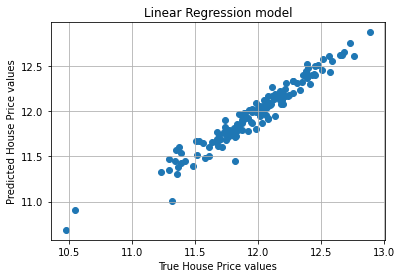

In [0]:
plt.scatter(valset_y, linear_reg_y_pred_val)
plt.xlabel("True House Price values")
plt.ylabel("Predicted House Price values")
plt.grid(True)
plt.title('Linear Regression model')
plt.show()

We are currently using 213 variables to train our model. That is, our model is generating 214 (together with the bias) coefficients which will linearly map the independent variable values to a specific house price. But on the other hand our model only has **993** examples to train from. Therefore the ratio of coefficient to example is approximately equal to **1/5**. There's no real rule of thumb on what the ratio between the coefficient and the number of examples must be but too many coefficients can lead to overfitting. Applying dimensionality reduction techniques like PCA is also not adviced since our examples contain both binary and non-binary numerical values and therefore it is difficult to find good linear encodings of the examples into a space of smaller dimension.

### Lasso Linear Regression

A very practical solution to the optimization of the parameter count is using a regulariser such as Lasso. Lasso regulariser is now basically an extension to Linear Regression where we want to have a best-fitted-line with the requirement that the coefficient sum falls below a certain value (say **t**). The variable **t** is what we call a hyper-parameter because unlike normal parameters, the best **t** is not found through optimization procedures. Unlike Ridge regulariser, Lasso makes the parameter vector sparse. We optimize **t** via **cross-validation** which is built inside 'sklearn.linear_model'.

In [0]:
lasso_lr = sklearn.linear_model.LassoCV(alphas=(.001, .001, .01, .1,.3, .5, 1,2,3,4,5,6,7,8,9,10),cv=10, max_iter = 4000)
lasso_model = lasso_lr.fit(trainset_X, trainset_y)
lasso_model_y_pred_val = lasso_model.predict(valset_X)
lasso_log_rmse_val = get_log_rmse(valset_y, lasso_model_y_pred_val)

print("Validation log-rmse: ", lasso_log_rmse_val)

Validation log-rmse:  9.24250303706369e-05


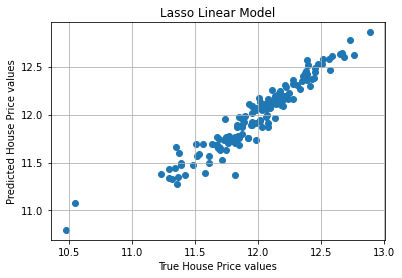

In [0]:
plt.scatter(valset_y, lasso_model_y_pred_val)
plt.xlabel("True House Price values")
plt.ylabel("Predicted House Price values")
plt.grid(True)
plt.title('Lasso Linear Model')
plt.show()

Lasso didn't do the job we wish we did for the whole data. But, from the plot we can see that for larger **SalePrice** values, Lasso does a better job than the vanilla linear regression model. 

We will compare all models in the end on the real testing data, for now our goal is to choose good models and increase the predictive power of them.

### Gaussian Process Regression

Unlike the vanilla Linear Regression, Gaussian processes infer a probability distribution over all possible values. The trick that it uses is it specifies some probability distribution over the model parameters. This allows the model to return a probabilities over the different possible 'slopes' of the fitted hyperplane by the Linear Regression.
This probabilistic approach allows us to specify confidence intervals over every prediction.

In [0]:
import sklearn.gaussian_process as gp

kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(trainset_X, trainset_y)
#params = model.kernel_.get_params()
y_pred, std = model.predict(valset_X, return_std=True)

bayes_log_rmse_val = get_log_rmse(valset_y, y_pred)
print("Validation log-rmse: ", bayes_log_rmse_val)

Validation log-rmse:  0.00020839705607460587


The performance of the model itself has been worse than the performance of the vanilla linear regression. But the power of the model falls in its confidence intervals.

In [0]:
j = 0
for i in range(len(valset_y)):
    if list(valset_y)[i] <= y_pred[i] + 2*std[i] and list(valset_y)[i] >= y_pred[i] - 2*std[i]:
        j=j+1
    else:
        pass

print("{}% of HousePrices fall inside the 95% confidence interval".format(np.round(j/len(valset_y),2)))

0.83% of HousePrices fall inside the 95% confidence interval


For 83% of the houses we have information on what range of values the price falls. This is a good since most of the times in regression tasks we would trade accuracy of exact prediction for crucial information like between what values we expect the price to fall. 

### Questioning linearity

Even though the linear models above achieved good performance on the data. Claiming that we can predict a continuous variable with high precision using a linear model is a strong assumption. One could perhaps make the statement that if house A is twice the size of house B then house A should cost twice as much as house B. But could you make a similar statement about each detail of the house? Probably not. Can we find a suitable kernel to solve such an issue? With the amount of variables it is unlikely.

Therefore a less extreme claim is that we can predict a continuous variable with high precision by not making any statement the its mapping with regards to the independent variables. This leads us to the use of **Random Forests**. 

### Random Forest Regressor

We saw above that some features have very high correlation with the **SalePrice**. We can think of these features as deterministic features in the non-traditional sense. That is, some highly corralated features can be used to closely approximate **SalePrice** and then less important features to close the small gap between our approximations and the true values. In other words there's some splitting hierarchy which if we follow we could obtain better predictions.

In [0]:
rf_reg = RandomForestRegressor(n_estimators = 600, n_jobs = -1, max_features = 0.5, random_state = 15)
rf_reg.fit(trainset_X, trainset_y)
rf_reg_y_pred = rf_reg.predict(valset_X)
rf_log_rmse = get_log_rmse(valset_y, rf_reg_y_pred)
print("Validation log-rmse: ", rf_log_rmse)

Validation log-rmse:  1.877698668729629e-05


The log-rmse for the Random Forest Regressor is the lowest of all the other models so far and we choose it as a winning model. It is of interest to see how the scatterplot for the Random Forest Regressor is distributed.

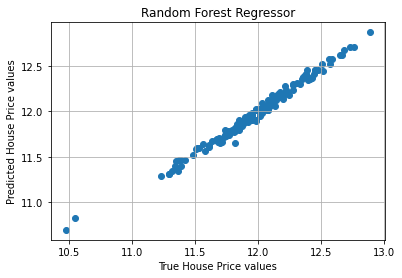

In [0]:
plt.scatter(valset_y, rf_reg_y_pred)
plt.xlabel("True House Price values")
plt.ylabel("Predicted House Price values")
plt.grid(True)
plt.title('Random Forest Regressor')
plt.show()

The scatterplot now shows that the mapping of the predicted values against the true values now lies within a much thinner diagonal due to increased accuracy. The most visible improvement on accuracy is noticed for houses of lower price. Thus, the non-linear model outperforms the linear ones.

## Predicting the test set

We retrained the models using all training data and made predictions on the testing data. 

The results for all the four models are viewed on the plots below. 

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

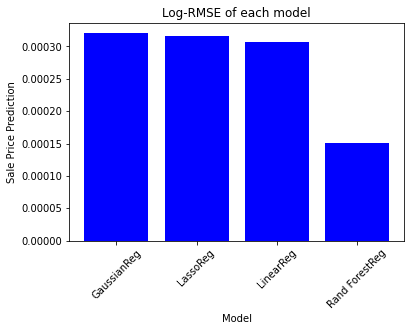

In [0]:
features = [linear_reg_y_pred_val, lasso_model_y_pred_val, y_pred, rf_reg_y_pred]
logs = [linear_log_rmse_test, lasso_log_rmse_test, bayes_log_rmse_test, rf_log_rmse]
names = ['GaussianReg', 'LassoReg', 'LinearReg', 'Rand ForestReg']

plt.bar(names, sorted(logs)[::-1], color = 'blue')
plt.ylabel('Sale Price Prediction')
plt.xlabel("Model")
plt.title('Log-RMSE of each model')
plt.xticks(rotation=45)

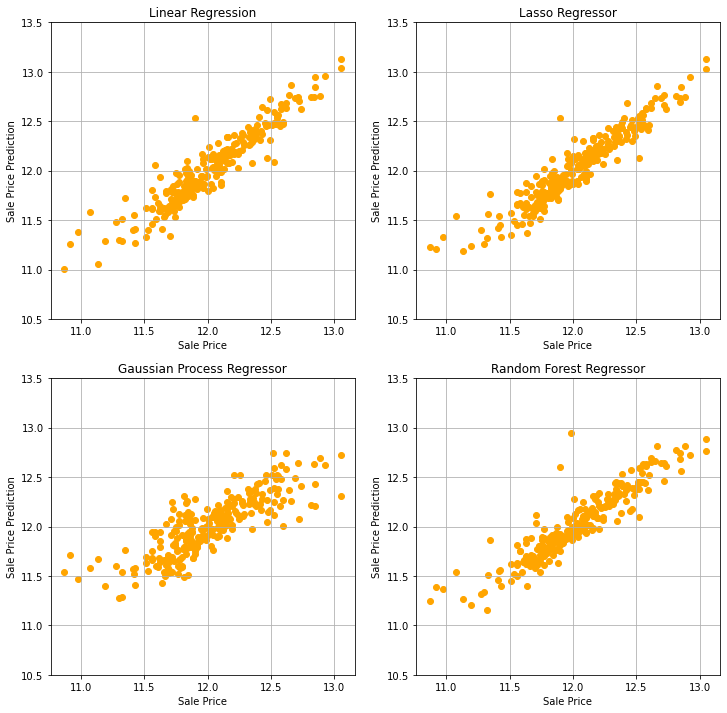

In [0]:
features = [linear_reg_y_pred_val, lasso_model_y_pred_val, y_pred, rf_reg_y_pred_test]
names = ['Linear Regression', 'Lasso Regressor', 'Gaussian Process Regressor', 'Random Forest Regressor']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
i=1
for f in features:
    
    plt.subplot(2, 2, i)
    
    plt.scatter(testset_y, f, color = 'orange')
    #plt.plot(trainset[f], trainset['SalePrice'], 'bo')
    plt.ylabel('Sale Price Prediction')
    plt.xlabel("Sale Price")
    plt.ylim(10.5, 13.5)
    plt.grid(True)
    plt.title(names[i-1])
    i = i+1

As we can see, the Random Forest Regressor still outclasses the other Regression models.

We now check what percentage of data fell within two standard deviations of the Gaussian Process Regressor

In [0]:
j = 0
for i in range(len(testset_X)):
    if list(testset_y)[i] <= y_pred[i] + 2*std[i] and list(testset_y)[i] >= y_pred[i] - 2*std[i]:
        j=j+1
    else:
        pass

print("{}% of HousePrices fall inside the 95% confidence interval".format(np.round(j/len(testset_y),2)))

0.78% of HousePrices fall inside the 95% confidence interval


So, we would have 'predicted' 78% of the data correctly with 95% confidence interval. 

## Conclusion

Based on the analysis made, we established that not all input features are essential. And thus, In order to operate with a sufficient number of features and reduce the model complexity, we remove the least correlated and similar values that do not affect the performance.

Given the models, the prediction on the test data was made using the "Gaussian regression process",  "Lasso Linear Regression", "Linear regression" and "RandomForest". And to process evaluation, the Root Mean Square Error (RMSE) on the logarithms was applied. 

As a result of performance, we want to note that the **“Random forest regression”** model is superior to the performance of other regression models and produced the lowest RMSE that can be seen in the graphs. 
